In [2]:
!pip install matplotlib numpy torchvision tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 244.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 146.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 266.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 268.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip



=== Training Task 1 ===


100%|██████████| 198/198 [00:00<00:00, 532.99it/s]


Epoch 1, Loss: 0.2242


100%|██████████| 198/198 [00:00<00:00, 484.05it/s]


Epoch 2, Loss: 0.0367
Accuracy on Task 1: 0.999

=== Training Task 2 ===


100%|██████████| 189/189 [00:01<00:00, 97.04it/s]


Epoch 1, Loss: 0.6550


100%|██████████| 189/189 [00:02<00:00, 93.32it/s]


Epoch 2, Loss: 0.2439
Accuracy on Task 1: 0.985
Accuracy on Task 2: 0.947

=== Training Task 3 ===


100%|██████████| 176/176 [00:03<00:00, 52.19it/s]


Epoch 1, Loss: 0.5101


100%|██████████| 176/176 [00:02<00:00, 59.51it/s]


Epoch 2, Loss: 0.2820
Accuracy on Task 1: 0.896
Accuracy on Task 2: 0.921
Accuracy on Task 3: 0.928

=== Training Task 4 ===


100%|██████████| 191/191 [00:04<00:00, 45.34it/s]


Epoch 1, Loss: 0.3658


100%|██████████| 191/191 [00:04<00:00, 42.45it/s]


Epoch 2, Loss: 0.1067
Accuracy on Task 1: 0.885
Accuracy on Task 2: 0.897
Accuracy on Task 3: 0.858
Accuracy on Task 4: 0.987

=== Training Task 5 ===


100%|██████████| 185/185 [00:05<00:00, 35.82it/s]


Epoch 1, Loss: 0.6079


100%|██████████| 185/185 [00:05<00:00, 35.09it/s]


Epoch 2, Loss: 0.2387
Accuracy on Task 1: 0.711
Accuracy on Task 2: 0.684
Accuracy on Task 3: 0.419
Accuracy on Task 4: 0.982
Accuracy on Task 5: 0.951
=== Continual Learning Metrics ===
Average Accuracy (ACC):       0.7493
Forgetting (F):              0.2664
Backward Transfer (BWT):     -0.2664
Forward Transfer (FWT):      0.0000
Memory Usage:                721.68 MB
Computation Cost:            939 projections/batch
Plasticity-Stability Measure (PSM): 0.3668 (0-1 normalized)
=== Metrics (Split MNIST) ===
ACC=0.7493, F=0.2664, BWT=-0.2664, FWT=0.0000, Mem=721.68MB, PSM=0.3668


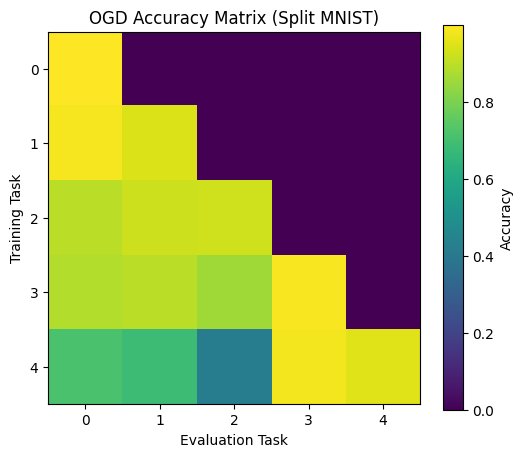

In [3]:
# Orthogonal Gradient Descent (OGD) for Continual Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=2):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))


# OGD Implementation
class OGD:
    def __init__(self, model, lr=0.01, device='cuda'):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # Memory of gradient directions from previous tasks

    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx: idx+numel].view_as(p))
                idx += numel

    def _project_grad(self, g):
        if len(self.S) == 0:
            return g
        g_proj = g.clone()
        for v in self.S:
            proj = (torch.dot(g_proj, v) / torch.dot(v, v)) * v
            g_proj -= proj
        return g_proj

    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        out = self.model(x)
        loss = criterion(out, y)
        loss.backward()

        g = self._flatten_grad()
        g_orth = self._project_grad(g)
        self._assign_grad(g_orth)
        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            out = self.model(x)
            loss = criterion(out, y)
            loss.backward()

            u = self._flatten_grad()
            u_proj = self._project_grad(u)
            norm_u_proj = u_proj / (u_proj.norm() + 1e-10)
            self.S.append(norm_u_proj.detach().clone())


# Prepare Split MNIST (5 tasks, 2 classes each)
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def split_dataset(dataset, classes):
    idx = np.isin(dataset.targets.numpy(), classes)
    data = dataset.data[idx].float()/255.0
    targets = dataset.targets[idx]
    mapping = {cls:i for i,cls in enumerate(classes)}
    targets = torch.tensor([mapping[t.item()] for t in targets])
    return TensorDataset(data.view(-1, 28*28), targets)

task_classes = [[0,1],[2,3],[4,5],[6,7],[8,9]]
train_tasks = [split_dataset(mnist_train, c) for c in task_classes]
test_tasks = [split_dataset(mnist_test, c) for c in task_classes]

# Training with Metrics
num_tasks = len(train_tasks)
num_epochs = 2
batch_size = 64

model = SimpleMLP(input_size=784, hidden_size=256, output_size=2)
ogd = OGD(model, lr=0.01, device=device)

accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            loss = ogd.observe(x, y)
            epoch_loss += loss
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all tasks seen so far
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(ogd.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    # End of task: store gradient directions
    ogd.end_task(train_loader)


# Compute Continual Learning Metrics
# Average Accuracy (ACC)
ACC = accuracy_matrix[-1].mean()  # Final row averaged across tasks

# Average Forgetting (F)
F = np.mean([
    np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j]
    for j in range(num_tasks-1)
])

# Backward Transfer (BWT)
BWT = np.mean([
    accuracy_matrix[-1, j] - accuracy_matrix[j, j]
    for j in range(num_tasks-1)
])

# Forward Transfer (FWT)
# Measures how much previous tasks helped the next task before it was trained
FWT = np.mean([
    accuracy_matrix[i, i+1]
    for i in range(num_tasks-1)
])

# Memory Usage (in MB)
num_params = sum(p.numel() for p in ogd.model.parameters())
mem_usage = len(ogd.S) * num_params * 4 / (1024**2)  # 4 bytes per float32

# 6. Computation Cost (Number of gradient projections per batch)
comp_cost = len(ogd.S)

# Plasticity-Stability Measure (PSM) - Normalized 0 to 1

# Define components
stability = 1 - F                 # High if forgetting is low
plasticity = max(FWT, 0)          # High if positive forward transfer

alpha = 0.5                       # Balance between stability and plasticity
PSM = alpha * stability + (1 - alpha) * plasticity

# Print Metrics
print("=== Continual Learning Metrics ===")
print(f"Average Accuracy (ACC):       {ACC:.4f}")
print(f"Forgetting (F):              {F:.4f}")
print(f"Backward Transfer (BWT):     {BWT:.4f}")
print(f"Forward Transfer (FWT):      {FWT:.4f}")
print(f"Memory Usage:                {mem_usage:.2f} MB")
print(f"Computation Cost:            {comp_cost} projections/batch")
print(f"Plasticity-Stability Measure (PSM): {PSM:.4f} (0-1 normalized)")

print("=== Metrics (Split MNIST) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('OGD Accuracy Matrix (Split MNIST)')
plt.show()


=== Training Task 1 ===


100%|██████████| 938/938 [00:02<00:00, 450.24it/s]


Epoch 1, Loss: 1.2260


100%|██████████| 938/938 [00:01<00:00, 498.59it/s]


Epoch 2, Loss: 0.4874
Accuracy on Task 1: 0.894

=== Training Task 2 ===


100%|██████████| 938/938 [00:33<00:00, 28.04it/s]


Epoch 1, Loss: 0.7786


100%|██████████| 938/938 [00:33<00:00, 28.14it/s]


Epoch 2, Loss: 0.4279
Accuracy on Task 1: 0.891
Accuracy on Task 2: 0.901

=== Training Task 3 ===


100%|██████████| 938/938 [01:04<00:00, 14.46it/s]


Epoch 1, Loss: 0.7596


100%|██████████| 938/938 [01:02<00:00, 14.92it/s]


Epoch 2, Loss: 0.4200
Accuracy on Task 1: 0.882
Accuracy on Task 2: 0.897
Accuracy on Task 3: 0.900
=== Metrics (Permuted MNIST) ===
ACC=0.8929, F=0.0082, BWT=-0.0082, FWT=0.0000, Mem=2184.80MB, PSM=0.4959


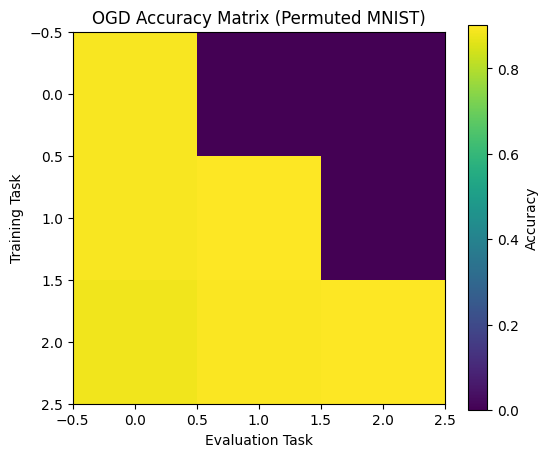

In [4]:
# =======================
# OGD on Permuted MNIST
# =======================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=10):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

# OGD Implementation
class OGD:
    def __init__(self, model, lr=0.01, device='cuda'):
        self.model = model.to(device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.device = device
        self.S = []  # Memory of gradient directions

    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx: idx+numel].view_as(p))
                idx += numel

    def _project_grad(self, g):
        if len(self.S) == 0: return g
        g_proj = g.clone()
        for v in self.S:
            proj = (torch.dot(g_proj, v) / torch.dot(v, v)) * v
            g_proj -= proj
        return g_proj

    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()

        g = self._flatten_grad()
        g_orth = self._project_grad(g)
        self._assign_grad(g_orth)
        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            loss = criterion(self.model(x), y)
            loss.backward()

            u = self._flatten_grad()
            u_proj = self._project_grad(u)
            norm_u_proj = u_proj / (u_proj.norm() + 1e-10)
            self.S.append(norm_u_proj.detach().clone())

# === Prepare 3 permuted MNIST tasks ===
num_tasks = 3
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_x = mnist_train.data.view(-1, 28*28).float()/255.0
test_x = mnist_test.data.view(-1, 28*28).float()/255.0
train_y = mnist_train.targets
test_y = mnist_test.targets

train_tasks, test_tasks = [], []
for _ in range(num_tasks):
    perm = torch.randperm(28*28)
    train_tasks.append(TensorDataset(train_x[:, perm], train_y))
    test_tasks.append(TensorDataset(test_x[:, perm], test_y))


# Training loop
num_epochs = 2
batch_size = 64
model = SimpleMLP()
ogd = OGD(model, lr=0.01, device=device)
accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            epoch_loss += ogd.observe(x, y)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(ogd.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    ogd.end_task(train_loader)

# === Metrics ===
ACC = accuracy_matrix[-1].mean()
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)]) if num_tasks>1 else 0.0

num_params = sum(p.numel() for p in ogd.model.parameters())
mem_usage = len(ogd.S) * num_params * 4 / (1024**2)
comp_cost = len(ogd.S)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("=== Metrics (Permuted MNIST) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('OGD Accuracy Matrix (Permuted MNIST)')
plt.show()

Device: cuda
Files already downloaded and verified
Files already downloaded and verified
Task 0: classes 0..9 | train 5000, test 1000
Task 1: classes 10..19 | train 5000, test 1000
Task 2: classes 20..29 | train 5000, test 1000
Task 3: classes 30..39 | train 5000, test 1000
Task 4: classes 40..49 | train 5000, test 1000
Task 5: classes 50..59 | train 5000, test 1000
Task 6: classes 60..69 | train 5000, test 1000
Task 7: classes 70..79 | train 5000, test 1000
Task 8: classes 80..89 | train 5000, test 1000
Task 9: classes 90..99 | train 5000, test 1000

=== Task 1/10 | classes 0..9 ===


Task 1 Epoch 1: 100%|██████████| 40/40 [00:00<00:00, 43.98it/s]


Epoch 1: loss=1.8425


Task 1 Epoch 2: 100%|██████████| 40/40 [00:00<00:00, 40.48it/s]

Epoch 2: loss=1.5343


Accuracy on Task 1: 0.411
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 30

=== Task 2/10 | classes 10..19 ===


Task 2 Epoch 1: 100%|██████████| 40/40 [00:00<00:00, 42.75it/s]


Epoch 1: loss=2.2337


Task 2 Epoch 2: 100%|██████████| 40/40 [00:00<00:00, 42.45it/s]

Epoch 2: loss=1.8415


Accuracy on Task 1: 0.086
Accuracy on Task 2: 0.345
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 60

=== Task 3/10 | classes 20..29 ===


Task 3 Epoch 1: 100%|██████████| 40/40 [00:00<00:00, 42.32it/s]


Epoch 1: loss=2.1406


Task 3 Epoch 2: 100%|██████████| 40/40 [00:00<00:00, 42.99it/s]

Epoch 2: loss=1.7829


Accuracy on Task 1: 0.126
Accuracy on Task 2: 0.115
Accuracy on Task 3: 0.403
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 90

=== Task 4/10 | classes 30..39 ===


Task 4 Epoch 1: 100%|██████████| 40/40 [00:00<00:00, 41.28it/s]


Epoch 1: loss=2.1401


Task 4 Epoch 2: 100%|██████████| 40/40 [00:00<00:00, 41.44it/s]

Epoch 2: loss=1.7457


Accuracy on Task 1: 0.097
Accuracy on Task 2: 0.146
Accuracy on Task 3: 0.106
Accuracy on Task 4: 0.363
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 120

=== Task 5/10 | classes 40..49 ===


Task 5 Epoch 1: 100%|██████████| 40/40 [00:00<00:00, 41.43it/s]


Epoch 1: loss=2.1206


Task 5 Epoch 2: 100%|██████████| 40/40 [00:00<00:00, 42.23it/s]

Epoch 2: loss=1.7178


Accuracy on Task 1: 0.096
Accuracy on Task 2: 0.096
Accuracy on Task 3: 0.089
Accuracy on Task 4: 0.146
Accuracy on Task 5: 0.424
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 150

=== Task 6/10 | classes 50..59 ===


Task 6 Epoch 1: 100%|██████████| 40/40 [00:00<00:00, 42.61it/s]


Epoch 1: loss=1.9489


Task 6 Epoch 2: 100%|██████████| 40/40 [00:00<00:00, 41.91it/s]

Epoch 2: loss=1.4554


Accuracy on Task 1: 0.083
Accuracy on Task 2: 0.080
Accuracy on Task 3: 0.073
Accuracy on Task 4: 0.044
Accuracy on Task 5: 0.196
Accuracy on Task 6: 0.484
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 180

=== Task 7/10 | classes 60..69 ===


Task 7 Epoch 1: 100%|██████████| 40/40 [00:00<00:00, 41.90it/s]


Epoch 1: loss=2.3056


Task 7 Epoch 2: 100%|██████████| 40/40 [00:00<00:00, 42.20it/s]

Epoch 2: loss=1.6508


Accuracy on Task 1: 0.115
Accuracy on Task 2: 0.093
Accuracy on Task 3: 0.083
Accuracy on Task 4: 0.097
Accuracy on Task 5: 0.115
Accuracy on Task 6: 0.063
Accuracy on Task 7: 0.433
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 210

=== Task 8/10 | classes 70..79 ===


Task 8 Epoch 1: 100%|██████████| 40/40 [00:00<00:00, 42.04it/s]


Epoch 1: loss=2.1727


Task 8 Epoch 2: 100%|██████████| 40/40 [00:00<00:00, 42.05it/s]

Epoch 2: loss=1.7017


Accuracy on Task 1: 0.180
Accuracy on Task 2: 0.103
Accuracy on Task 3: 0.103
Accuracy on Task 4: 0.091
Accuracy on Task 5: 0.074
Accuracy on Task 6: 0.076
Accuracy on Task 7: 0.080
Accuracy on Task 8: 0.407
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 240

=== Task 9/10 | classes 80..89 ===


Task 9 Epoch 1: 100%|██████████| 40/40 [00:00<00:00, 41.70it/s]


Epoch 1: loss=2.0978


Task 9 Epoch 2: 100%|██████████| 40/40 [00:00<00:00, 41.41it/s]

Epoch 2: loss=1.6362


Accuracy on Task 1: 0.053
Accuracy on Task 2: 0.096
Accuracy on Task 3: 0.086
Accuracy on Task 4: 0.095
Accuracy on Task 5: 0.140
Accuracy on Task 6: 0.105
Accuracy on Task 7: 0.093
Accuracy on Task 8: 0.077
Accuracy on Task 9: 0.440
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 270

=== Task 10/10 | classes 90..99 ===


Task 10 Epoch 1: 100%|██████████| 40/40 [00:00<00:00, 42.18it/s]


Epoch 1: loss=2.2371


Task 10 Epoch 2: 100%|██████████| 40/40 [00:00<00:00, 42.68it/s]

Epoch 2: loss=1.6540


Accuracy on Task 1: 0.077
Accuracy on Task 2: 0.038
Accuracy on Task 3: 0.128
Accuracy on Task 4: 0.073
Accuracy on Task 5: 0.057
Accuracy on Task 6: 0.079
Accuracy on Task 7: 0.184
Accuracy on Task 8: 0.118
Accuracy on Task 9: 0.127
Accuracy on Task 10: 0.462
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 300

=== Metrics (Split CIFAR-100, CNN, OGD) ===
ACC=0.1343, F=0.3143, BWT=-0.3143, FWT=0.0000, Mem=710.46 MB, PSM=0.3428


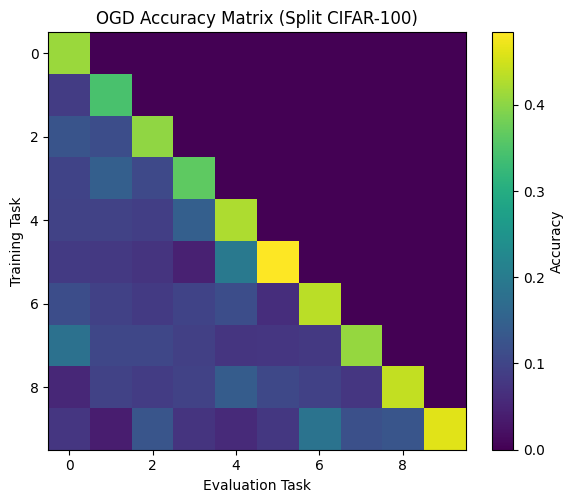

In [15]:
# ================================================
# OGD on Split CIFAR-100 (10 tasks × 10 classes)
# ================================================
# - Memory-efficient task construction
# - OGD with orthonormal gradient memory
# - Stores optimizer/criterion in OGD (Option 2)
# - Accuracy matrix + CL metrics + plot
# ================================================

import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------
# Repro & Device
# -----------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------
# Hyperparameters
# -----------------
root = "./data"
num_tasks = 10
num_classes = 100
classes_per_task = num_classes // num_tasks  # 10
batch_size = 128
num_epochs = 2
download = True

# Optimizer/loss
learning_rate = 0.05
weight_decay = 5e-4
momentum = 0.9

# OGD memory
max_mem_dirs = 1000   # cap on number of stored gradient directions (global)
dirs_per_task = 120   # target number of new directions to add per task
harvest_batches = 30  # batches to sample for memory after each task
grad_eps = 1e-6       # min norm to accept a direction

# -----------------
# Transforms
# -----------------
normalize = transforms.Normalize(mean=(0.5071, 0.4867, 0.4408),
                                 std=(0.2675, 0.2565, 0.2761))
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# -----------------
# Datasets
# -----------------
train_full = datasets.CIFAR100(root=root, train=True,  download=download, transform=train_transform)
test_full  = datasets.CIFAR100(root=root, train=False, download=download, transform=test_transform)

train_targets = np.array(train_full.targets)
test_targets  = np.array(test_full.targets)

# -----------------
# Task splits (indices & class lists)
# -----------------
task_class_lists = []
train_indices_per_task, test_indices_per_task = [], []

for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))
    task_class_lists.append(task_classes)

    train_idx = np.where(np.isin(train_targets, task_classes))[0].tolist()
    test_idx  = np.where(np.isin(test_targets,  task_classes))[0].tolist()

    train_indices_per_task.append(train_idx)
    test_indices_per_task.append(test_idx)

    print(f"Task {t}: classes {task_classes[0]}..{task_classes[-1]} | "
          f"train {len(train_idx)}, test {len(test_idx)}")

# -----------------
# Per-task label mapping dataset
# -----------------
class MapLabelsDataset(Dataset):
    def __init__(self, base_dataset, indices, class_map):
        self.base = base_dataset
        self.indices = indices
        self.class_map = class_map

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.base[self.indices[i]]
        return x, self.class_map[int(y)]

# -----------------
# Model
# -----------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # 32x16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # 64x8x8
        x = self.pool(F.relu(self.bn3(self.conv3(x))))   # 128x4x4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -----------------
# Utils to flatten/assign grads
# -----------------
def flatten_grads(model):
    parts = []
    for p in model.parameters():
        if p.requires_grad and p.grad is not None:
            parts.append(p.grad.view(-1))
    return torch.cat(parts) if parts else torch.tensor([], device=next(model.parameters()).device)

def assign_grads_from_vector(model, grad_vec):
    offset = 0
    for p in model.parameters():
        if not p.requires_grad:
            continue
        n = p.numel()
        if p.grad is None:
            p.grad = torch.zeros_like(p)
        p.grad.copy_(grad_vec[offset:offset+n].view_as(p))
        offset += n

# -----------------
# OGD (Option 2: stores optimizer & criterion internally)
# -----------------
class OGD:
    def __init__(self, model, optimizer, criterion, device,
                 max_mem_dirs=1000, grad_eps=1e-6):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

        self.P = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.memory = None   # [k, P], orthonormal rows (unit-norm)
        self.max_mem_dirs = max_mem_dirs
        self.grad_eps = grad_eps

    @torch.no_grad()
    def _project_onto_complement(self, g):
        # g: [P]
        if self.memory is None or self.memory.size(0) == 0:
            return g
        # Memory rows are orthonormal ⇒ projection is g_perp = g - M^T (M g)
        Mg = torch.mv(self.memory, g)            # [k]
        g_perp = g - torch.mv(self.memory.t(), Mg)
        return g_perp

    @torch.no_grad()
    def _add_dir_to_memory(self, g):
        # Gram-Schmidt orth against existing memory; if large enough, normalize & append
        if self.memory is not None and self.memory.size(0) > 0:
            Mg = torch.mv(self.memory, g)
            g = g - torch.mv(self.memory.t(), Mg)
        norm = torch.linalg.norm(g)
        if norm > self.grad_eps:
            g = g / norm
            if self.memory is None:
                self.memory = g.unsqueeze(0)
            else:
                if self.memory.size(0) < self.max_mem_dirs:
                    self.memory = torch.vstack([self.memory, g])
                else:
                    # Replace a random row to maintain diversity (FIFO/random policy)
                    idx = torch.randint(0, self.memory.size(0), (1,)).item()
                    self.memory[idx] = g

    def observe(self, x, y):
        """One OGD training step on a batch."""
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)

        self.optimizer.zero_grad(set_to_none=True)
        logits = self.model(x)
        loss = self.criterion(logits, y)
        loss.backward()

        # Flatten grads → project → assign → step
        g = flatten_grads(self.model).detach()
        g_perp = self._project_onto_complement(g)
        assign_grads_from_vector(self.model, g_perp)
        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, dirs_to_add=100, harvest_batches=30):
        """Harvest gradient directions (from current task) to expand memory."""
        self.model.train()
        for p in self.model.parameters():
            p.requires_grad_(True)
        torch.set_grad_enabled(True)

        added, seen = 0, 0
        for xb, yb in dataloader:
            if seen >= harvest_batches or added >= dirs_to_add:
                break
            seen += 1

            xb, yb = xb.to(self.device), yb.to(self.device)
            self.model.zero_grad(set_to_none=True)
            logits = self.model(xb)
            loss = self.criterion(logits, yb)
            loss.backward()

            g = flatten_grads(self.model).detach()
            self._add_dir_to_memory(g)
            added += 1

        print(f"[OGD] Harvested {added} dirs (seen {seen} batches). "
              f"Memory size: {0 if self.memory is None else self.memory.size(0)}")

# -----------------
# Eval
# -----------------
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return correct / max(1, total)

# -----------------
# Init model/optimizer/criterion/OGD
# -----------------
model = SimpleCNN(num_classes=classes_per_task).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

ogd = OGD(model, optimizer, criterion, device,
          max_mem_dirs=max_mem_dirs, grad_eps=grad_eps)

# -----------------
# Train across tasks
# -----------------
accuracy_matrix = np.zeros((num_tasks, num_tasks), dtype=np.float32)

loader_kwargs = dict(num_workers=2, pin_memory=True) if device.type == "cuda" else dict(num_workers=0)

for t in range(num_tasks):
    # Datasets & loaders for task t (labels remapped to 0..9)
    class_map = {orig: i for i, orig in enumerate(task_class_lists[t])}
    train_ds_t = MapLabelsDataset(train_full, train_indices_per_task[t], class_map)
    test_ds_t  = MapLabelsDataset(test_full,  test_indices_per_task[t],  class_map)

    train_loader = DataLoader(train_ds_t, batch_size=batch_size, shuffle=True,  **loader_kwargs)
    test_loader  = DataLoader(test_ds_t,  batch_size=batch_size, shuffle=False, **loader_kwargs)

    print(f"\n=== Task {t+1}/{num_tasks} | classes {task_class_lists[t][0]}..{task_class_lists[t][-1]} ===")
    for epoch in range(1, num_epochs + 1):
        running = 0.0
        for xb, yb in tqdm(train_loader, desc=f"Task {t+1} Epoch {epoch}"):
            running += ogd.observe(xb, yb)
        print(f"Epoch {epoch}: loss={running/len(train_loader):.4f}")

    # Evaluate on all seen tasks so far
    for j in range(t + 1):
        class_map_eval = {orig: i for i, orig in enumerate(task_class_lists[j])}
        test_ds_eval = MapLabelsDataset(test_full, test_indices_per_task[j], class_map_eval)
        test_loader_eval = DataLoader(test_ds_eval, batch_size=batch_size, shuffle=False, **loader_kwargs)
        acc = evaluate(ogd.model, test_loader_eval, device)
        accuracy_matrix[t, j] = acc
        print(f"Accuracy on Task {j+1}: {acc:.3f}")

    # Grow OGD memory from current task data
    ogd.end_task(train_loader, dirs_to_add=dirs_per_task, harvest_batches=harvest_batches)

# -----------------
# Metrics
# -----------------
ACC = accuracy_matrix[-1, :].mean()
if num_tasks > 1:
    F   = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)])
    BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)])
    FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)])
else:
    F = BWT = FWT = 0.0

P = sum(p.numel() for p in ogd.model.parameters() if p.requires_grad)
k = 0 if ogd.memory is None else ogd.memory.size(0)
mem_usage_mb = (k * P * 4) / (1024**2)  # float32
PSM = 0.5 * (1 - F) + 0.5 * max(FWT, 0)

print("\n=== Metrics (Split CIFAR-100, CNN, OGD) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage_mb:.2f} MB, PSM={PSM:.4f}")

# -----------------
# Plot accuracy matrix
# -----------------
plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('OGD Accuracy Matrix (Split CIFAR-100 CNN)')
plt.tight_layout()
plt.show()

Device: cuda

=== Task 1/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 1 Epoch 1: 100%|██████████| 391/391 [00:08<00:00, 46.17it/s]


Epoch 1: loss=4.3553


Task 1 Epoch 2: 100%|██████████| 391/391 [00:07<00:00, 51.69it/s]


Epoch 2: loss=4.0520
Files already downloaded and verified
Accuracy on Task 1: 0.079
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 30

=== Task 2/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 2 Epoch 1: 100%|██████████| 391/391 [00:07<00:00, 52.86it/s]


Epoch 1: loss=3.9949


Task 2 Epoch 2: 100%|██████████| 391/391 [00:08<00:00, 47.78it/s]


Epoch 2: loss=3.8563
Files already downloaded and verified
Accuracy on Task 1: 0.030
Files already downloaded and verified
Accuracy on Task 2: 0.112
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 60

=== Task 3/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 3 Epoch 1: 100%|██████████| 391/391 [00:08<00:00, 47.34it/s]


Epoch 1: loss=3.9428


Task 3 Epoch 2: 100%|██████████| 391/391 [00:08<00:00, 47.24it/s]


Epoch 2: loss=3.7860
Files already downloaded and verified
Accuracy on Task 1: 0.019
Files already downloaded and verified
Accuracy on Task 2: 0.027
Files already downloaded and verified
Accuracy on Task 3: 0.111
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 90

=== Task 4/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 4 Epoch 1: 100%|██████████| 391/391 [00:08<00:00, 47.36it/s]


Epoch 1: loss=3.8826


Task 4 Epoch 2: 100%|██████████| 391/391 [00:07<00:00, 48.96it/s]


Epoch 2: loss=3.7314
Files already downloaded and verified
Accuracy on Task 1: 0.021
Files already downloaded and verified
Accuracy on Task 2: 0.021
Files already downloaded and verified
Accuracy on Task 3: 0.051
Files already downloaded and verified
Accuracy on Task 4: 0.133
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 120

=== Task 5/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 5 Epoch 1: 100%|██████████| 391/391 [00:07<00:00, 50.22it/s]


Epoch 1: loss=3.8511


Task 5 Epoch 2: 100%|██████████| 391/391 [00:07<00:00, 49.22it/s]


Epoch 2: loss=3.6942
Files already downloaded and verified
Accuracy on Task 1: 0.025
Files already downloaded and verified
Accuracy on Task 2: 0.025
Files already downloaded and verified
Accuracy on Task 3: 0.034
Files already downloaded and verified
Accuracy on Task 4: 0.053
Files already downloaded and verified
Accuracy on Task 5: 0.138
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 150

=== Task 6/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 6 Epoch 1: 100%|██████████| 391/391 [00:08<00:00, 48.74it/s]


Epoch 1: loss=3.8738


Task 6 Epoch 2: 100%|██████████| 391/391 [00:08<00:00, 46.93it/s]


Epoch 2: loss=3.6944
Files already downloaded and verified
Accuracy on Task 1: 0.024
Files already downloaded and verified
Accuracy on Task 2: 0.028
Files already downloaded and verified
Accuracy on Task 3: 0.024
Files already downloaded and verified
Accuracy on Task 4: 0.027
Files already downloaded and verified
Accuracy on Task 5: 0.044
Files already downloaded and verified
Accuracy on Task 6: 0.143
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 180

=== Task 7/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 7 Epoch 1: 100%|██████████| 391/391 [00:08<00:00, 46.56it/s]


Epoch 1: loss=3.8539


Task 7 Epoch 2: 100%|██████████| 391/391 [00:07<00:00, 53.01it/s]


Epoch 2: loss=3.6714
Files already downloaded and verified
Accuracy on Task 1: 0.027
Files already downloaded and verified
Accuracy on Task 2: 0.025
Files already downloaded and verified
Accuracy on Task 3: 0.026
Files already downloaded and verified
Accuracy on Task 4: 0.028
Files already downloaded and verified
Accuracy on Task 5: 0.025
Files already downloaded and verified
Accuracy on Task 6: 0.048
Files already downloaded and verified
Accuracy on Task 7: 0.139
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 210

=== Task 8/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 8 Epoch 1: 100%|██████████| 391/391 [00:07<00:00, 49.35it/s]


Epoch 1: loss=3.8363


Task 8 Epoch 2: 100%|██████████| 391/391 [00:07<00:00, 49.23it/s]


Epoch 2: loss=3.6677
Files already downloaded and verified
Accuracy on Task 1: 0.022
Files already downloaded and verified
Accuracy on Task 2: 0.022
Files already downloaded and verified
Accuracy on Task 3: 0.023
Files already downloaded and verified
Accuracy on Task 4: 0.024
Files already downloaded and verified
Accuracy on Task 5: 0.034
Files already downloaded and verified
Accuracy on Task 6: 0.028
Files already downloaded and verified
Accuracy on Task 7: 0.049
Files already downloaded and verified
Accuracy on Task 8: 0.147
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 240

=== Task 9/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 9 Epoch 1: 100%|██████████| 391/391 [00:07<00:00, 52.77it/s]


Epoch 1: loss=3.8193


Task 9 Epoch 2: 100%|██████████| 391/391 [00:07<00:00, 50.71it/s]


Epoch 2: loss=3.6572
Files already downloaded and verified
Accuracy on Task 1: 0.026
Files already downloaded and verified
Accuracy on Task 2: 0.027
Files already downloaded and verified
Accuracy on Task 3: 0.029
Files already downloaded and verified
Accuracy on Task 4: 0.028
Files already downloaded and verified
Accuracy on Task 5: 0.030
Files already downloaded and verified
Accuracy on Task 6: 0.026
Files already downloaded and verified
Accuracy on Task 7: 0.032
Files already downloaded and verified
Accuracy on Task 8: 0.060
Files already downloaded and verified
Accuracy on Task 9: 0.154
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 270

=== Task 10/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 10 Epoch 1: 100%|██████████| 391/391 [00:08<00:00, 47.22it/s]


Epoch 1: loss=3.8005


Task 10 Epoch 2: 100%|██████████| 391/391 [00:08<00:00, 47.88it/s]


Epoch 2: loss=3.6356
Files already downloaded and verified
Accuracy on Task 1: 0.027
Files already downloaded and verified
Accuracy on Task 2: 0.027
Files already downloaded and verified
Accuracy on Task 3: 0.028
Files already downloaded and verified
Accuracy on Task 4: 0.025
Files already downloaded and verified
Accuracy on Task 5: 0.028
Files already downloaded and verified
Accuracy on Task 6: 0.025
Files already downloaded and verified
Accuracy on Task 7: 0.031
Files already downloaded and verified
Accuracy on Task 8: 0.035
Files already downloaded and verified
Accuracy on Task 9: 0.058
Files already downloaded and verified
Accuracy on Task 10: 0.150
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 300

=== Metrics (Permuted CIFAR-100, CNN, OGD) ===
ACC=0.0434, F=0.0967, BWT=-0.0967, FWT=0.0000, Mem=736.93 MB, PSM=0.4517


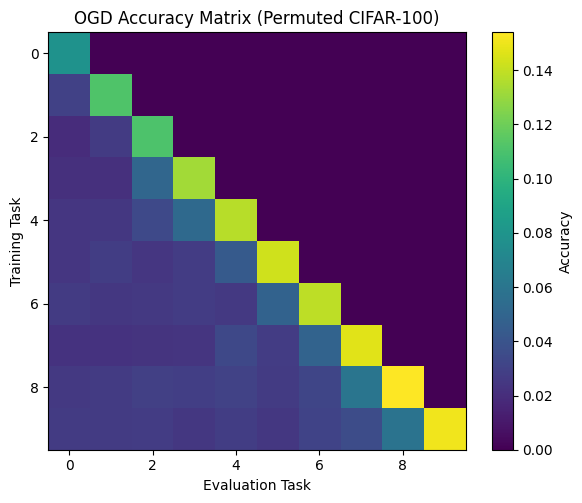

In [3]:
# ====================================================
# OGD on Permuted CIFAR-100 (num_tasks × 100 classes)
# ====================================================
# - Same CNN & OGD implementation as Split CIFAR-100
# - Each task has a unique, fixed pixel permutation
# - Full label space per task (0..99)
# ====================================================

import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------
# Repro & Device
# -----------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------
# Hyperparameters
# -----------------
root = "./data"
num_tasks = 10
num_classes = 100
batch_size = 128
num_epochs = 2
download = True

# Optimizer/loss
learning_rate = 0.05
weight_decay = 5e-4
momentum = 0.9

# OGD memory
max_mem_dirs = 1000
dirs_per_task = 120
harvest_batches = 30
grad_eps = 1e-6

# -----------------
# Base normalization
# -----------------
normalize = transforms.Normalize(mean=(0.5071, 0.4867, 0.4408),
                                 std=(0.2675, 0.2565, 0.2761))

# -----------------
# Generate pixel permutations for each task
# -----------------
img_size = 32
num_pixels = img_size * img_size * 3
permutations = [torch.randperm(num_pixels) for _ in range(num_tasks)]

class PermutePixels:
    """Transform to permute pixels using a fixed order."""
    def __init__(self, perm):
        self.perm = perm

    def __call__(self, img):
        # img: Tensor [C,H,W]
        c, h, w = img.size()
        flat = img.view(-1)
        permuted = flat[self.perm]
        return permuted.view(c, h, w)

# -----------------
# Model
# -----------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -----------------
# Utils for grads
# -----------------
def flatten_grads(model):
    parts = []
    for p in model.parameters():
        if p.requires_grad and p.grad is not None:
            parts.append(p.grad.view(-1))
    return torch.cat(parts) if parts else torch.tensor([], device=next(model.parameters()).device)

def assign_grads_from_vector(model, grad_vec):
    offset = 0
    for p in model.parameters():
        if not p.requires_grad:
            continue
        n = p.numel()
        if p.grad is None:
            p.grad = torch.zeros_like(p)
        p.grad.copy_(grad_vec[offset:offset+n].view_as(p))
        offset += n

# -----------------
# OGD (same as before)
# -----------------
class OGD:
    def __init__(self, model, optimizer, criterion, device,
                 max_mem_dirs=1000, grad_eps=1e-6):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

        self.P = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.memory = None
        self.max_mem_dirs = max_mem_dirs
        self.grad_eps = grad_eps

    @torch.no_grad()
    def _project_onto_complement(self, g):
        if self.memory is None or self.memory.size(0) == 0:
            return g
        Mg = torch.mv(self.memory, g)
        g_perp = g - torch.mv(self.memory.t(), Mg)
        return g_perp

    @torch.no_grad()
    def _add_dir_to_memory(self, g):
        if self.memory is not None and self.memory.size(0) > 0:
            Mg = torch.mv(self.memory, g)
            g = g - torch.mv(self.memory.t(), Mg)
        norm = torch.linalg.norm(g)
        if norm > self.grad_eps:
            g = g / norm
            if self.memory is None:
                self.memory = g.unsqueeze(0)
            else:
                if self.memory.size(0) < self.max_mem_dirs:
                    self.memory = torch.vstack([self.memory, g])
                else:
                    idx = torch.randint(0, self.memory.size(0), (1,)).item()
                    self.memory[idx] = g

    def observe(self, x, y):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)

        self.optimizer.zero_grad(set_to_none=True)
        logits = self.model(x)
        loss = self.criterion(logits, y)
        loss.backward()

        g = flatten_grads(self.model).detach()
        g_perp = self._project_onto_complement(g)
        assign_grads_from_vector(self.model, g_perp)
        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, dirs_to_add=100, harvest_batches=30):
        self.model.train()
        for p in self.model.parameters():
            p.requires_grad_(True)
        torch.set_grad_enabled(True)

        added, seen = 0, 0
        for xb, yb in dataloader:
            if seen >= harvest_batches or added >= dirs_to_add:
                break
            seen += 1

            xb, yb = xb.to(self.device), yb.to(self.device)
            self.model.zero_grad(set_to_none=True)
            logits = self.model(xb)
            loss = self.criterion(logits, yb)
            loss.backward()

            g = flatten_grads(self.model).detach()
            self._add_dir_to_memory(g)
            added += 1

        print(f"[OGD] Harvested {added} dirs (seen {seen} batches). "
              f"Memory size: {0 if self.memory is None else self.memory.size(0)}")

# -----------------
# Eval
# -----------------
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return correct / max(1, total)

# -----------------
# Init
# -----------------
model = SimpleCNN(num_classes=num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
ogd = OGD(model, optimizer, criterion, device,
          max_mem_dirs=max_mem_dirs, grad_eps=grad_eps)

accuracy_matrix = np.zeros((num_tasks, num_tasks), dtype=np.float32)
loader_kwargs = dict(num_workers=2, pin_memory=True) if device.type == "cuda" else dict(num_workers=0)

# -----------------
# Train across permuted tasks
# -----------------
for t in range(num_tasks):
    print(f"\n=== Task {t+1}/{num_tasks} (unique pixel permutation) ===")
    
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        PermutePixels(permutations[t]),
        normalize
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        PermutePixels(permutations[t]),
        normalize
    ])

    train_ds_t = datasets.CIFAR100(root=root, train=True, download=download, transform=train_transform)
    test_ds_t  = datasets.CIFAR100(root=root, train=False, download=download, transform=test_transform)

    train_loader = DataLoader(train_ds_t, batch_size=batch_size, shuffle=True, **loader_kwargs)
    test_loader  = DataLoader(test_ds_t, batch_size=batch_size, shuffle=False, **loader_kwargs)

    for epoch in range(1, num_epochs + 1):
        running = 0.0
        for xb, yb in tqdm(train_loader, desc=f"Task {t+1} Epoch {epoch}"):
            running += ogd.observe(xb, yb)
        print(f"Epoch {epoch}: loss={running/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for j in range(t + 1):
        eval_transform = transforms.Compose([
            transforms.ToTensor(),
            PermutePixels(permutations[j]),
            normalize
        ])
        eval_ds = datasets.CIFAR100(root=root, train=False, download=download, transform=eval_transform)
        eval_loader = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, **loader_kwargs)
        acc = evaluate(ogd.model, eval_loader, device)
        accuracy_matrix[t, j] = acc
        print(f"Accuracy on Task {j+1}: {acc:.3f}")

    ogd.end_task(train_loader, dirs_to_add=dirs_per_task, harvest_batches=harvest_batches)

# -----------------
# Metrics
# -----------------
ACC = accuracy_matrix[-1, :].mean()
if num_tasks > 1:
    F   = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)])
    BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)])
    FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)])
else:
    F = BWT = FWT = 0.0

P = sum(p.numel() for p in ogd.model.parameters() if p.requires_grad)
k = 0 if ogd.memory is None else ogd.memory.size(0)
mem_usage_mb = (k * P * 4) / (1024**2)
PSM = 0.5 * (1 - F) + 0.5 * max(FWT, 0)

print("\n=== Metrics (Permuted CIFAR-100, CNN, OGD) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage_mb:.2f} MB, PSM={PSM:.4f}")

# -----------------
# Plot
# -----------------
plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('OGD Accuracy Matrix (Permuted CIFAR-100 CNN)')
plt.tight_layout()
plt.show()